# Graphic output of the Random Forests models

## Preparing data

In [1]:
import pandas as pd

waves_filepath = 'C:/Users/Andre/Documents/GitHub/BEDU-Data-Analysis/data/Coastal Data System - Waves (Mooloolaba) 01-2017 to 06 - 2019.csv'
waves_data = pd.read_csv(waves_filepath, index_col=False)
waves_data = waves_data.rename(columns={"Date/Time":"time",
                                        'Hs':'wave_height',
                                        'Hmax':'max_wave_height',
                                        'Tz':'zero_upcrossing_wave_period',
                                        'Tp':'peak_energy_wave_period',
                                        'Peak Direction':'peak_direction',
                                        'SST':'temperature'})

waves_data_clean = waves_data[(waves_data.wave_height > 0) &
                              (waves_data.max_wave_height > 0) &
                              (waves_data.zero_upcrossing_wave_period > 0) &
                              (waves_data.peak_energy_wave_period > 0) &
                              (waves_data.peak_direction > 0) &
                              (waves_data.temperature > 0)]

waves_data_sample = waves_data_clean.iloc[41727:] # 1727 rows

## MLA

### Model 1: without max_wave_height

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

y = waves_data_sample.wave_height
y_tr = y.iloc[:1295]
y_te = y.iloc[1295:]

features = ['zero_upcrossing_wave_period','peak_energy_wave_period','peak_direction','temperature']
X = waves_data_sample[features]
X_tr = X.iloc[:1295]
X_te = X.iloc[1295:]

# 1/4 select
rf_model = RandomForestRegressor(random_state=1)
# 2/4 fit
rf_model.fit(X_tr, y_tr)
# 3/4 predict
wave_height_preds = rf_model.predict(X_te)
# 4/4 validate
MAE = mean_absolute_error(y_te, wave_height_preds)

print("The Mean Absolute Error is {0:.2f} meters.".format(MAE))

The Mean Absolute Error is 0.97 meters.


### Model 2: with max_wave_height

In [3]:
features = ['max_wave_height','zero_upcrossing_wave_period','peak_energy_wave_period','peak_direction','temperature']
Z = waves_data_sample[features]
Z_tr = Z.iloc[:1295]
Z_te = Z.iloc[1295:]

# 1/4 select
rf_model_b = RandomForestRegressor(random_state=1)
# 2/4 fit
rf_model_b.fit(Z_tr, y_tr)
# 3/4 predict
wave_height_preds_b = rf_model_b.predict(Z_te)
# 4/4 validate
MAE_b = mean_absolute_error(y_te, wave_height_preds_b)

print("The Mean Absolute Error of the second model is {0:.2f} meters.".format(MAE_b))

The Mean Absolute Error of the second model is 0.25 meters.


## Graphs

In [12]:
train_df = y_tr.to_frame(name='wave_height')
train_df['type'] = 'train'
train_df['time'] = waves_data_sample.iloc[:1295]['time'].to_numpy()
# train_df

In [13]:
test_df = y_te.to_frame(name='wave_height')
test_df['type'] = 'test'
test_df['time'] = waves_data_sample.iloc[1295:]['time'].to_numpy()
# test_df

In [14]:
pred_df = y_te.to_frame(name='wave_height_test')
pred_df['wave_height_pred'] = wave_height_preds
pred_df = pred_df.drop(['wave_height_test'], axis=1).rename(columns={"wave_height_pred":"wave_height"})
pred_df['type'] = 'model 1'
pred_df['time'] = waves_data_sample.iloc[1295:]['time'].to_numpy()
# pred_df

In [15]:
pred_b_df = y_te.to_frame(name='wave_height_test')
pred_b_df['wave_height_pred'] = wave_height_preds_b
pred_b_df = pred_b_df.drop(['wave_height_test'], axis=1).rename(columns={"wave_height_pred":"wave_height"})
pred_b_df['type'] = 'model 2'
pred_b_df['time'] = waves_data_sample.iloc[1295:]['time'].to_numpy()
# pred_b_df

In [16]:
train_test_df = train_df.append(test_df)
models_df = pred_df.append(pred_b_df)
final_df = train_test_df.append(models_df)

In [17]:
final_df

,wave_height,type,time
41994,0.75100,train,25/05/2019 21:00
41995,0.73500,train,25/05/2019 21:30
41996,0.74500,train,25/05/2019 22:00
41997,0.80000,train,25/05/2019 22:30
41998,0.70300,train,25/05/2019 23:00
...,...,...,...
43723,1.69097,model 2,30/06/2019 21:30
43724,1.69819,model 2,30/06/2019 22:00
43725,1.69208,model 2,30/06/2019 22:30
43726,1.59530,model 2,30/06/2019 23:00


In [18]:
final_df.groupby(['type']).size()

type
model 1     432
model 2     432
test        432
train      1295
dtype: int64

[[<matplotlib.axis.XTick at 0x18a6a9aef70>,

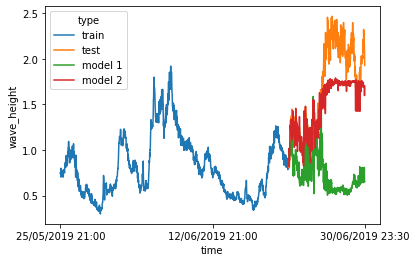

In [21]:
import seaborn as sns

sns.lineplot(x=final_df['time'], y=final_df['wave_height'], hue=final_df['type'])\
    .set(xticks=[0,863,1726])  